Approach 3 – Large & Regularized / Long-memory Combined

Lookback window: 90

Layers: 3

Units: 128

Dropout: 0.3

Optimizer: Adam (learning rate = 0.0005)

Loss: MSE

Batch size: 16

Epochs: up to 200

In [ ]:
# ====================== Imports & Reproducibility ======================
import os, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Model
from IPython.display import display

np.random.seed(42)
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

TensorFlow: 2.19.0


In [ ]:
# ====================== Config ======================
CSV_PATH    = "../dataset/TSLA.csv"   # <-- change if your path is different
DATE_COL    = "Date"
CLOSE_COL   = "Close"
TRAIN_START = "2015-01-12"

# Approach: Combined LSTM+GRU
LOOKBACK    = 90      # shorter history
EPOCHS      = 200     # max epochs
BATCH_SIZE  = 16      # batch size

LSTM_UNITS   = 128     # 64 units in LSTM
GRU_UNITS    = 128     # 64 units in GRU
LSTM_LAYERS  = 3      # one LSTM layer
GRU_LAYERS   = 3      # one GRU layer
LSTM_DROPOUT = 0.3    # dropout 0.1 (applied after each recurrent block)

# Splits (chronological): 80% / 10% / 10%
TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10

In [ ]:
CSV_PATH = "/content/TSLA.csv" # Update this path after uploading the file
import os
print(os.path.exists(CSV_PATH))

True


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-12,13.536667,13.631333,13.283333,13.480667,13.480667,89254500
2015-01-13,13.554667,13.840667,13.394000,13.616667,13.616667,67159500
2015-01-14,12.388667,13.013333,12.333333,12.846000,12.846000,173278500


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-06-11,173.919998,174.750000,167.410004,170.660004,170.660004,64761900
2024-06-12,171.119995,180.550003,169.800003,177.289993,177.289993,89884800
2024-06-13,188.427994,191.050003,181.940094,184.434998,184.434998,97297153


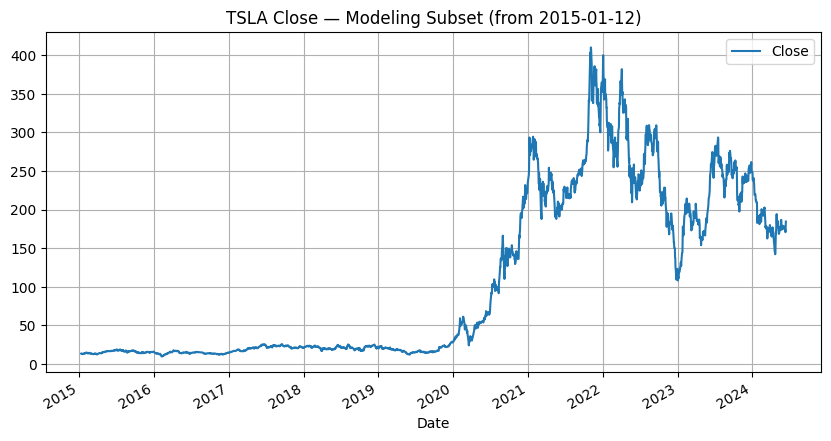

In [ ]:
# ====================== Load, clean, plot ======================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Update CSV_PATH.")

df = pd.read_csv(CSV_PATH)
if DATE_COL not in df.columns or CLOSE_COL not in df.columns:
    raise ValueError(f"Expected '{DATE_COL}' and '{CLOSE_COL}' in columns: {df.columns.tolist()}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True).set_index(DATE_COL)

df = df[df.index >= TRAIN_START].copy()

# Handle missing Close values if any
if df[CLOSE_COL].isna().any():
    df[CLOSE_COL] = (
        df[CLOSE_COL]
        .interpolate(method="time")
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

display(df.head(3))
display(df.tail(3))

df[[CLOSE_COL]].plot(title=f"TSLA Close — Modeling Subset (from {TRAIN_START})")
plt.show()

In [ ]:
# ====================== Chronological 80/10/10 split (no leakage) ======================
close_values = df[[CLOSE_COL]].values.astype("float32")
n = len(close_values)
n_train = int(np.floor(TRAIN_RATIO * n))
n_val   = int(np.floor(VAL_RATIO   * n))
n_test  = n - n_train - n_val

assert n_train > LOOKBACK and n_val > 0 and n_test > 0, "Not enough data for chosen LOOKBACK/splits."

train_raw = close_values[:n_train]
val_raw   = close_values[n_train:n_train+n_val]
test_raw  = close_values[n_train+n_val:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_raw)  # fit on train only
train_scaled = scaler.transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

In [ ]:
# ====================== Windowing util ======================
def make_xy(series_2d, lookback=60):
    """
    series_2d: shape (N, 1).
    Returns:
        X: (samples, lookback, 1)
        y: (samples,)
    """
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i - lookback:i, 0])
        y.append(series_2d[i, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X.reshape((X.shape[0], X.shape[1], 1)), y


# Train windows come purely from train
X_train, y_train = make_xy(train_scaled, LOOKBACK)

# Validation windows need LOOKBACK context from the end of train
val_with_ctx = np.concatenate([train_scaled[-LOOKBACK:], val_scaled], axis=0)
X_val, y_val = make_xy(val_with_ctx, LOOKBACK)  # -> exactly len(val_scaled) samples
# Test windows need LOOKBACK context from the end of val
test_with_ctx = np.concatenate([val_scaled[-LOOKBACK:], test_scaled], axis=0)
X_test, y_test = make_xy(test_with_ctx, LOOKBACK)  # -> exactly len(test_scaled) samples

print("Shapes:",
      "\n  X_train", X_train.shape, "y_train", y_train.shape,
      "\n  X_val  ", X_val.shape,   "y_val  ", y_val.shape,
      "\n  X_test ", X_test.shape,  "y_test ", y_test.shape)

Shapes: 
  X_train (1807, 90, 1) y_train (1807,) 
  X_val   (237, 90, 1) y_val   (237,) 
  X_test  (238, 90, 1) y_test  (238,)


In [ ]:
# ====================== Combined LSTM+GRU model ======================
def build_lstm_gru(lookback=90, units=128,
                   lstm_layers=3, gru_layers=3, dropout=0.3):
    """
    Combined model:
      Input: (lookback, 1)
      LSTM stack -> GRU stack -> Dense(1)
    """
    inp = layers.Input(shape=(lookback, 1))
    x = inp

    # LSTM stack
    for i in range(max(1, lstm_layers)):
        return_seq = True  # we want sequences for GRU
        x = layers.LSTM(units, return_sequences=True)(x)
        x = layers.Dropout(dropout)(x)

    # GRU stack
    # First (gru_layers - 1) GRU layers with return_sequences=True
    for i in range(max(0, gru_layers - 1)):
        x = layers.GRU(units, return_sequences=True)(x)
        x = layers.Dropout(dropout)(x)

    # Last GRU layer without return_sequences
    x = layers.GRU(units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
# ====================== Timing & per-epoch Test evaluation ======================
class TimeAndTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test, self.y_test = X_test, y_test
        self.cum_times = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self._t0 = None

    def on_train_begin(self, logs=None):
        self._t0 = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        t_now = time.perf_counter()
        self.cum_times.append(t_now - self._t0)
        self.train_losses.append(float(logs.get("loss", np.nan)))
        self.val_losses.append(float(logs.get("val_loss", np.nan)))
        test_loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        self.test_losses.append(float(test_loss))

    def to_frame(self):
        df_log = pd.DataFrame({
            "epoch": np.arange(1, len(self.cum_times) + 1),
            "time_sec_cum": self.cum_times,
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "test_loss": self.test_losses
        })
        df_log["train_rmse"] = np.sqrt(df_log["train_loss"])
        df_log["test_rmse"]  = np.sqrt(df_log["test_loss"])
        return df_log


def timed_fit(model, X_train, y_train, X_val, y_val, X_test, y_test,
              epochs=EPOCHS, batch_size=BATCH_SIZE):
    tcb = TimeAndTestCallback(X_test, y_test)
    es  = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        verbose=1, shuffle=False,
        callbacks=[tcb, es]
    )
    return hist, tcb.to_frame()


In [ ]:
# ====================== Train ONCE (timed) ======================
COMBO_UNITS = LSTM_UNITS # Or GRU_UNITS, as they are both 128
COMBO_DROPOUT = LSTM_DROPOUT

combo_model = build_lstm_gru(
    lookback=LOOKBACK,
    units=COMBO_UNITS,
    lstm_layers=LSTM_LAYERS,
    gru_layers=GRU_LAYERS,
    dropout=COMBO_DROPOUT
)
print(combo_model.summary())

_, log_df = timed_fit(
    combo_model, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

display(log_df.head())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 90, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 90, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,073 (2.39 MB)

 Trainable params: 627,073 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 500ms/step - loss: 0.0021 - val_loss: 0.0515
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - loss: 0.0660 - val_loss: 0.0181
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - loss: 0.0412 - val_loss: 0.0178
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 481ms/step - loss: 0.0394 - val_loss: 0.0177
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 54s 480ms/step - loss: 0.0407 - val_loss: 0.0175
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 469ms/step - loss: 0.0429 - val_loss: 0.0189
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 484ms/step - loss: 0.0455 - val_loss: 0.0213
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - loss: 0.0517 - val_loss: 0.0177
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 479ms/step - loss: 0.0551 - val_loss: 0.0195
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 468ms/step - loss: 0.0567 - val_loss: 0.0178
Epoch 11/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - loss: 0.0606 - val_loss: 0.1082
Epo

,epoch,time_sec_cum,train_loss,val_loss,test_loss,train_rmse,test_rmse
0,1,64.355399,0.012111,0.051536,0.037104,0.110049,0.192625
1,2,119.317723,0.031824,0.018094,0.008758,0.178393,0.093583
2,3,200.617450,0.029922,0.017786,0.009592,0.172981,0.097938
3,4,282.490488,0.029841,0.017689,0.008910,0.172746,0.094392
4,5,336.677137,0.026041,0.017544,0.008697,0.161371,0.093259


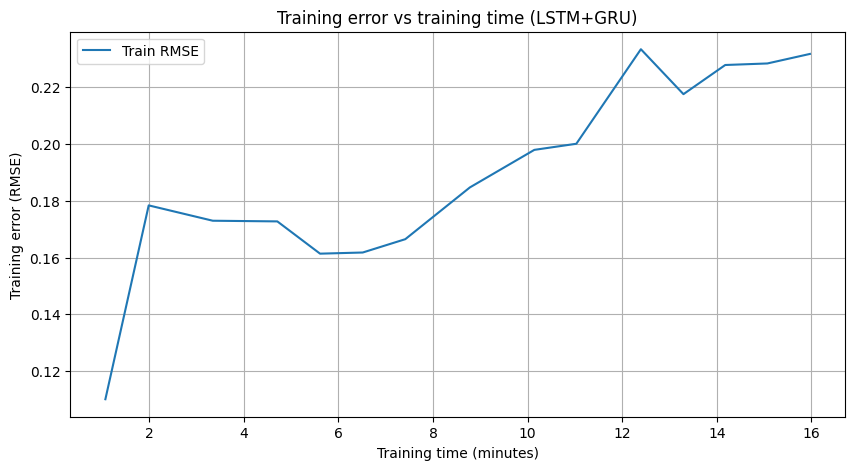

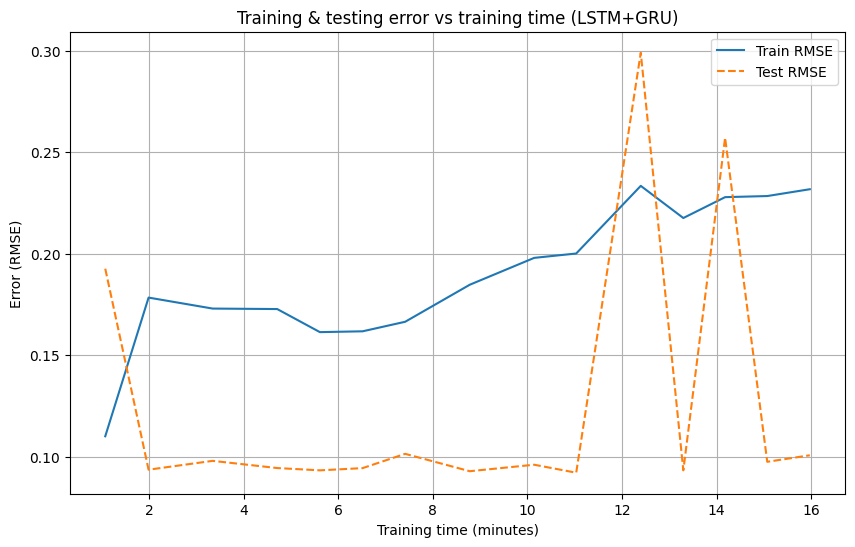

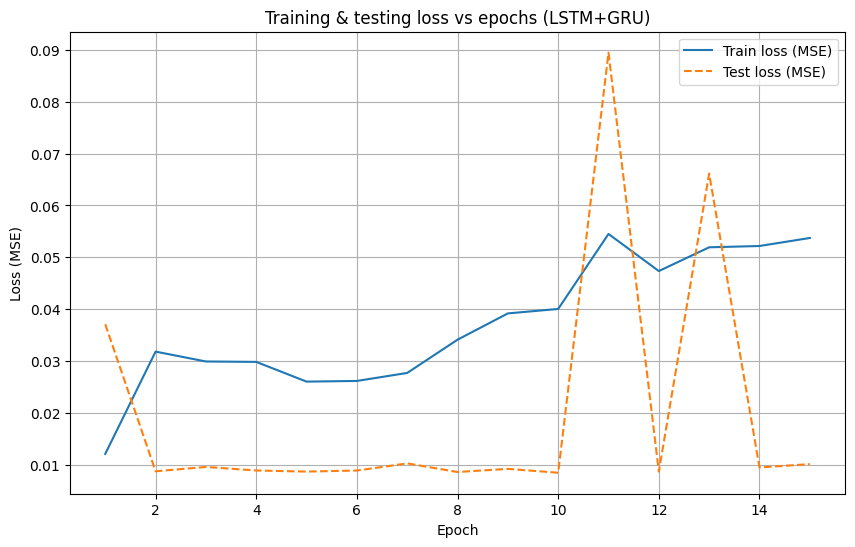

In [ ]:
# ====================== Required Plots ======================
# 1) Training error vs training time
plt.figure(figsize=(10,5))
plt.plot(log_df["time_sec_cum"]/60.0, log_df["train_rmse"], label="Train RMSE")
plt.xlabel("Training time (minutes)")
plt.ylabel("Training error (RMSE)")
plt.title("Training error vs training time (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 2) Training & testing error vs training time
plt.figure(figsize=(10,6))
plt.plot(log_df["time_sec_cum"]/60.0, log_df["train_rmse"], label="Train RMSE")
plt.plot(log_df["time_sec_cum"]/60.0, log_df["test_rmse"],  linestyle="--", label="Test RMSE")
plt.xlabel("Training time (minutes)")
plt.ylabel("Error (RMSE)")
plt.title("Training & testing error vs training time (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

# 3) Loss (training & testing) vs epochs
plt.figure(figsize=(10,6))
plt.plot(log_df["epoch"], log_df["train_loss"], label="Train loss (MSE)")
plt.plot(log_df["epoch"], log_df["test_loss"],  linestyle="--", label="Test loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & testing loss vs epochs (LSTM+GRU)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ====================== TEST endpoint predictions & metrics for H in {1,7,15} ======================
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def collect_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "RMSE": rmse(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred),
    }


def endpoint_results_for_H(model, H, use_val_context=True, model_name_prefix="LSTM+GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TEST at horizon H.
    use_val_context=True -> test windows may use LOOKBACK context from validation (matches X_test construction).
    """
    scaled_full = scaler.transform(close_values).ravel()
    start_test = n_train + n_val
    n_total = len(scaled_full)

    # start index policy
    if use_val_context:
        start_t = max(start_test, LOOKBACK)              # allow context from val
    else:
        start_t = max(start_test + LOOKBACK, LOOKBACK)   # force window fully inside test

    end_t = n_total - H
    dates, true_end, pred_end = [], [], []

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t]
        w = window.reshape(1, LOOKBACK, 1).copy()

        # recursive k-step to reach the H-th step
        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]
            w = np.concatenate([w[:, 1:, :], np.array(p).reshape(1, 1, 1)], axis=1)

        pred_end.append(p)
        true_end.append(scaled_full[t + H - 1])
        dates.append(df.index[t + H - 1])

        inv_true = scaler.inverse_transform(np.array(true_end).reshape(-1,1)).ravel()
    inv_pred = scaler.inverse_transform(np.array(pred_end).reshape(-1,1)).ravel()

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )
    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Test metrics (H={H}): {m}")
    return results, m


# Run for H = 1, 7, 15 on TEST
results_1,  metrics_1  = endpoint_results_for_H(combo_model, H=1,  use_val_context=True)
display(results_1.head())

results_7,  metrics_7  = endpoint_results_for_H(combo_model, H=7,  use_val_context=True)
display(results_7.head())

results_15, metrics_15 = endpoint_results_for_H(combo_model, H=15, use_val_context=True)
display(results_15.head())

# Optional summary table (TEST)
summary_test = pd.DataFrame([metrics_1, metrics_7, metrics_15])[["Model","RMSE","MSE","MAE","R2"]]
display(
    summary_test
        .style.format({"RMSE":"{:.4f}","MSE":"{:.4f}","MAE":"{:.4f}","R2":"{:.4f}"})
        .set_caption("TEST metrics by horizon (LSTM+GRU)")
)

Test metrics (H=1): {'Model': 'LSTM+GRU(H=1)', 'RMSE': 37.374434961238876, 'MSE': 1396.848388671875, 'MAE': 33.553321838378906, 'R2': -0.025224924087524414}


,Actual,LSTM+GRU(H=1)
Date,,
2023-07-06,276.540009,212.140167
2023-07-07,274.429993,212.140274
2023-07-10,269.609985,212.135223
2023-07-11,269.790009,212.126862
2023-07-12,271.989990,212.117966


Test metrics (H=7): {'Model': 'LSTM+GRU(H=7)', 'RMSE': 36.446314797310954, 'MSE': 1328.3338623046875, 'MAE': 32.744529724121094, 'R2': -0.0114213228225708}


,Actual,LSTM+GRU(H=7)
Date,,
2023-07-14,281.380005,212.273758
2023-07-17,290.380005,212.266449
2023-07-18,293.339996,212.263214
2023-07-19,291.260010,212.265839
2023-07-20,262.899994,212.269562


Test metrics (H=15): {'Model': 'LSTM+GRU(H=15)', 'RMSE': 34.84746687014172, 'MSE': 1214.345947265625, 'MAE': 31.519935607910156, 'R2': 0.001356959342956543}


,Actual,LSTM+GRU(H=15)
Date,,
2023-07-26,264.350006,212.462936
2023-07-27,255.710007,212.466278
2023-07-28,266.440002,212.469482
2023-07-31,267.429993,212.472000
2023-08-01,261.070007,212.474060


,Model,RMSE,MSE,MAE,R2
0,LSTM+GRU(H=1),37.3744,1396.8484,33.5533,-0.0252
1,LSTM+GRU(H=7),36.4463,1328.3339,32.7445,-0.0114
2,LSTM+GRU(H=15),34.8475,1214.3459,31.5199,0.0014


In [ ]:
# ====================== TRAIN endpoint metrics for H in {1,7,15} ======================
def endpoint_train_results_for_H(model, H, model_name_prefix="LSTM+GRU"):
    """
    Build Actual vs Predicted (endpoint-only) for TRAIN at horizon H.
    Uses only the train region (no val/test in the input window).
    """
    scaled_full = scaler.transform(close_values).ravel()

    dates, true_end, pred_end = [], [], []

    # windows and endpoints must stay inside [0, n_train)
    start_t = LOOKBACK          # need LOOKBACK history
    end_t   = n_train - H       # keep H-th step inside train

    for t in range(start_t, end_t):
        window = scaled_full[t-LOOKBACK:t]
        w = window.reshape(1, LOOKBACK, 1).copy()

        # recursive k-step to reach the H-th step
        p = None
        for _ in range(H):
            p = model.predict(w, verbose=0)[0, 0]
            w = np.concatenate([w[:, 1:, :], np.array(p).reshape(1, 1, 1)], axis=1)

        pred_end.append(p)
        true_end.append(scaled_full[t + H - 1])
        dates.append(df.index[t + H - 1])

    inv_true = scaler.inverse_transform(np.array(true_end).reshape(-1, 1)).ravel()
    inv_pred = scaler.inverse_transform(np.array(pred_end).reshape(-1, 1)).ravel()

    col_name = f"{model_name_prefix}(H={H})"
    results = pd.DataFrame(
        {"Actual": inv_true, col_name: inv_pred},
        index=pd.DatetimeIndex(dates, name="Date"),
    )

    m = collect_metrics(col_name, results["Actual"], results[col_name])
    print(f"Train metrics (H={H}): {m}")
    return results, m


# TRAIN metrics by horizon
train_res_1,  train_metrics_1  = endpoint_train_results_for_H(combo_model, H=1)
train_res_7,  train_metrics_7  = endpoint_train_results_for_H(combo_model, H=7)
train_res_15, train_metrics_15 = endpoint_train_results_for_H(combo_model, H=15)

summary_train = pd.DataFrame(
    [train_metrics_1, train_metrics_7, train_metrics_15]
)[["Model", "RMSE", "MSE", "MAE", "R2"]]

display(
    summary_train
        .style.format({"RMSE": "{:.4f}", "MSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})
        .set_caption("TRAIN metrics by horizon (LSTM+GRU)")
)


Train metrics (H=1): {'Model': 'LSTM+GRU(H=1)', 'RMSE': 167.74510401759866, 'MSE': 28138.419921875, 'MAE': 154.77444458007812, 'R2': -1.4876527786254883}
Train metrics (H=7): {'Model': 'LSTM+GRU(H=7)', 'RMSE': 167.13988808031434, 'MSE': 27935.7421875, 'MAE': 154.1744842529297, 'R2': -1.4647984504699707}
Train metrics (H=15): {'Model': 'LSTM+GRU(H=15)', 'RMSE': 166.4759566442704, 'MSE': 27714.244140625, 'MAE': 153.5045166015625, 'R2': -1.438720703125}


,Model,RMSE,MSE,MAE,R2
0,LSTM+GRU(H=1),167.7451,28138.4199,154.7744,-1.4877
1,LSTM+GRU(H=7),167.1399,27935.7422,154.1745,-1.4648
2,LSTM+GRU(H=15),166.4760,27714.2441,153.5045,-1.4387
